In [262]:
import pulp as plp
from random import seed
from random import randint
import numpy as np

 
## Bus driver schedulling 


Dit notebook is gemaakt voor een case waar buschauffeur worden gescheduled aan de trips in een dag (9-17). Er zijn 4 verschillende routes in San Fransisco (A,B,C,D) die om het uur vertrekken en terugkomen bij locatie X. Route A & B duurt in totaal 2 uur tot hij weer bij locatie X is aangekomen, terwijl C & D maar 1 uur duren. Deze trips moeten assigned worden aan buschauffeur die op oproep basis in dienst zijn bij de vervoerder. Echter zijn er verschillende CAO regels mbt buschauffeurs waar de vervoerder aan moet voldoen:
  1. buschauffeurs krijgen voor ieder uur dat ze een bus besturen 12 euro betaald
  2. Ze krijgen minimaal voor 4 uur rijden betaald.
  3. Voor ieder uur dat ze overwerken (>8 uur) krijgen ze 1,5 uur betaald
  4. Elke buschauffeur moet na 3 uur rijden minimaal 1 uur pauze houden
  5. Buschauffeurs moeten een divers rooster rijden: maximaal 3 x dezelfde route op 1 dag.
 

# Genereren van routes

In [263]:
from collections import defaultdict
from pprint import pprint
import random

def generate_trips(route_names, start_hour, end_hour):
  set_of_trips = {}
  for route_name in route_names: 
    for hour in range(start_hour, end_hour):
        if (route_name =="A") or (route_name=="C"):
            trip = {"route":route_name,'departure_time':hour, 'arrival_time': hour+1,"duration": 1}     
            set_of_trips["{}:{}-{}".format(route_name,hour,hour+1)]= trip
        else:
            trip = {"route":route_name,'departure_time':hour, 'arrival_time': hour+2,'duration':2}
            set_of_trips["{}:{}-{}".format(route_name,hour,hour+2)]= trip
  return set_of_trips



In [264]:
routes = 'ABCD'
start_hour = 8
end_hour = start_hour + 8
trips = generate_trips(routes, start_hour, end_hour)
print("Alle trips zitten in een dictionary:")
print("------------------------------------")
print(trips)

Alle trips zitten in een dictionary:
------------------------------------
{'A:8-9': {'route': 'A', 'departure_time': 8, 'arrival_time': 9, 'duration': 1}, 'A:9-10': {'route': 'A', 'departure_time': 9, 'arrival_time': 10, 'duration': 1}, 'A:10-11': {'route': 'A', 'departure_time': 10, 'arrival_time': 11, 'duration': 1}, 'A:11-12': {'route': 'A', 'departure_time': 11, 'arrival_time': 12, 'duration': 1}, 'A:12-13': {'route': 'A', 'departure_time': 12, 'arrival_time': 13, 'duration': 1}, 'A:13-14': {'route': 'A', 'departure_time': 13, 'arrival_time': 14, 'duration': 1}, 'A:14-15': {'route': 'A', 'departure_time': 14, 'arrival_time': 15, 'duration': 1}, 'A:15-16': {'route': 'A', 'departure_time': 15, 'arrival_time': 16, 'duration': 1}, 'B:8-10': {'route': 'B', 'departure_time': 8, 'arrival_time': 10, 'duration': 2}, 'B:9-11': {'route': 'B', 'departure_time': 9, 'arrival_time': 11, 'duration': 2}, 'B:10-12': {'route': 'B', 'departure_time': 10, 'arrival_time': 12, 'duration': 2}, 'B:11-13': 

# A) Bepaal alle mogelijke dagroosters/duties
Bepaal met behulp van een graph alle mogelijke dagroosters/duties

In [265]:
import networkx as nx
def generate_all_possible_duties(trips):
    # input is the trips of the problem
    arcs=[]
    start_node = "start_of_the_day"
    final_node = "end_of_the_day"
    for from_trip in trips:
        arcs.append([start_node,from_trip])
        arcs.append([from_trip,final_node])
        for to_trip in trips:
            #max 2 hours between two trips!
            if (trips[from_trip]['arrival_time']<=trips[to_trip]["departure_time"]) and  (trips[to_trip]["departure_time"]-trips[from_trip]['arrival_time']<2):
                arcs.append([from_trip, to_trip])

    directed_graph = {}

    directed_graph = nx.DiGraph()

    # Add all nodes to the networkx graph
    directed_graph.add_nodes_from(trips)

    #add all compatible arcs to the networkx graph
    directed_graph.add_edges_from([(arc[0], arc[1]) for arc in arcs])

    all_duties=[]
    duties = nx.all_simple_paths(directed_graph, start_node, final_node)
    all_duties.extend(duties)
    return all_duties


In [266]:
trips = generate_trips(routes, start_hour, end_hour)
duties = generate_all_possible_duties(trips)
print('Het netwerk heeft mbv alle paden van start van de dag tot einde alle duties gemaakt. Hier een sample van 5 willekeurige')
for _ in range(0,5):
    idx_duty = randint(0, len(duties))
    print(duties[idx_duty])


Het netwerk heeft mbv alle paden van start van de dag tot einde alle duties gemaakt. Hier een sample van 5 willekeurige
['start_of_the_day', 'C:8-9', 'C:10-11', 'A:12-13', 'C:13-14', 'C:14-15', 'C:15-16', 'end_of_the_day']
['start_of_the_day', 'C:9-10', 'C:10-11', 'A:11-12', 'A:13-14', 'D:14-16', 'end_of_the_day']
['start_of_the_day', 'C:8-9', 'C:9-10', 'A:10-11', 'C:11-12', 'A:12-13', 'A:13-14', 'C:14-15', 'end_of_the_day']
['start_of_the_day', 'C:8-9', 'A:9-10', 'A:10-11', 'A:11-12', 'C:12-13', 'C:13-14', 'A:14-15', 'end_of_the_day']
['start_of_the_day', 'D:9-11', 'A:11-12', 'A:12-13', 'C:13-14', 'A:14-15', 'A:15-16', 'end_of_the_day']


# Voeg kosten toe a.d.h.v CAO en betalings regels

In [316]:
def cost(duty,all_trips):
  """
  parameter voor overuren
  1. De vervoerder betaald 70 euro als ze een cheaffeaur een dag willen inhuren
  2. buschauffeurs krijgen voor ieder uur dat ze een bus rijden 12 euro betaald
  3. Ze krijgen minimaal voor 4 euro rijden betaald.
  4. Voor ieder uur dat ze overwerken (6 > uur) krijgen ze 1,5 uur uitbetaald
  5. Ze worden voor uren dat ze niet rijden maar wel op werk zijn 6 euro betaald. 
  6. Elke buschauffeur moet na 3 uur rijden minimaal 1 uur pauze houden
  
  OPTIONAL
  7. Diversiteit: Buschauffeurs moeten een divers rooster rijden: maximaal 3 x dezelfde route op 1 dag.
  """
  # Rule 1
    
  # Rule 2

  # Rule 3
    
  # Rule 4
    
  # Rule 5


  duty = duty[1:-1]  # remover start en end node
    
  total_hours_worked = all_trips[duty[-1]]['arrival_time'] - all_trips[duty[0]]['departure_time'] 
  total_hours_driven = sum([all_trips[duty_trip]['duration'] for duty_trip in duty])
  
  # Rule 1
  pay = 70
    
  # Rule 2 & 3
  pay += max(total_hours_driven * 12,12*4)
    
  # Rule 4   
  if total_hours_driven > 5:
    pay += (1.2 * (total_hours_driven-3))*12
  
  # rule 5
  break_hours = max(total_hours_worked - total_hours_driven,0)
  pay += break_hours * 4
    
#   # rule 6
#   subsequent_hours = 0 
#   arrival_time_previous = all_trips[duty[0]]['departure_time']

#   for duty_trip in duty:
#     if arrival_time_previous==all_trips[duty_trip]['departure_time']:
#        subsequent_hours +=all_trips[duty_trip]['duration']
#     else:
#        subsequent_hours = 0
    
#     if subsequent_hours> 3:
#         pay=1000000
#     arrival_time_previous = all_trips[duty_trip]['arrival_time']

#   # rule 7
#   route = [all_trips[duty_trip]['route'] for duty_trip in duty]
#   diversity_route = [True for trip in np.unique(route) if route.count(trip)>2]
#   if len(diversity_route)>0:
#     pay = 1000000
  return pay

## PuLP Solver
Deze functies lossen het set partitioning problem op!

In [317]:
def solve(duties, trips):
  problem = plp.LpProblem('driver_scheduling', plp.LpMinimize)
  variables = []
  costs = []
  # Data structure to generate constraints for each trip.
  variables_for_trip = {trip: [] for trip in trips}

  # We have to make sure there's some set of duties that really do include all
  # the trips. Since we randomly generate duties, we can't be sure. E.g., we
  # could get unlucky and randomly generate duties that all only have trips on
  # the 'A' route. To solve this problem, generate one duty for each trip that
  # includes only that trip.
  duties = duties # + [[trip] for trip in trips]

  # Gather up variables and costs
  for i, duty in enumerate(duties):
    # Create a binary variable (the value can be only 0 or 1)
    x = plp.LpVariable('x{}'.format(i + 1), 0, 1, plp.LpBinary)
    variables.append(x)
    costs.append(duty[0])
    for trip in duty[1]:
      variables_for_trip[trip].append(x)

  # Create the objective function. lpDot is shorthand for
  # c * x for (c, x) in zip(costs, variables)
  problem += plp.lpDot(costs, variables)

  # Create constraints that for each trip, exactly one x from the duties
  # including it must be 1.
  for xs in variables_for_trip.values():
    problem += plp.lpSum(xs) == 1

  # Pulp gives a very nice string representation of the problem when printed.
  #print(problem)
  status = problem.solve()
  print(plp.LpStatus[status])

  # We have a solution, now look at the values of xs to determine which duties
  # to use. Sum the cost for each used duty.
  solution = []
  total_cost = 0
  for i, x in enumerate(variables):
    if x.value():
      solution.append(duties[i])
      total_cost += costs[i]
  return solution, total_cost


In [318]:

def plot_gantt_chart():# Importing the matplotlb.pyplot 
    import matplotlib.pyplot as plt 

    # Declaring a figure "gnt" 
    fig, gnt = plt.subplots() 

    # Setting Y-axis limits 
    gnt.set_ylim(-1, len(solution_duties)) 

    # Setting X-axis limits 
    gnt.set_xlim(8, 19) 

    # Setting labels for x-axis and y-axis 
    gnt.set_xlabel('Hour of the day') 
    gnt.set_ylabel('Route') 

    # Setting ticks on y-axis 
    gnt.set_yticks([i+0.25 for i in range(0,len(solution_duties)+1)]) 
    # Labelling tickes of y-axis 
    gnt.set_yticklabels(['driver ' + str(i) for i in range(1,len(solution_duties)+1)]) 
    color = ["red","green",'blue','black']

    counter = 0
    gnt.grid(True) 
    for driver in solution_duties:
        for driver_trips in driver[1]:
            arrival_time = trips[driver_trips]["arrival_time"]
            departure_time = trips[driver_trips]["departure_time"]
            route = ord(trips[driver_trips]["route"])-65
            gnt.broken_barh([(departure_time, arrival_time-departure_time)], (counter, 0.5), facecolors =color[route],edgecolor='white',linewidth=2) 
        counter+=1
    # Plot colorbar
    plt.show()      

## Test het scenario

lenght of trips is {} 36
number of duties is {} 91332
calculated the costs of each duty
Optimal
Cost: 1442
[(130, ['A:8-9', 'D:9-11', 'B:11-13']),
 (138, ['A:10-11', 'A:12-13', 'D:14-16', 'C:16-17']),
 (130, ['B:8-10', 'B:10-12', 'C:12-13']),
 (134, ['B:9-11', 'C:11-12', 'D:13-15']),
 (130, ['B:12-14', 'A:14-15', 'B:15-17']),
 (130, ['B:13-15', 'C:15-16', 'D:16-18']),
 (130, ['C:8-9', 'A:9-10', 'C:10-11', 'D:11-13']),
 (142, ['C:9-10', 'A:11-12', 'A:13-14', 'D:15-17']),
 (130, ['C:13-14', 'B:14-16', 'B:16-18']),
 (118, ['D:8-10', 'D:10-12']),
 (130, ['D:12-14', 'C:14-15', 'A:15-16', 'A:16-17'])]


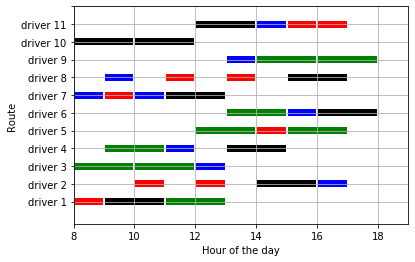

In [319]:
import numpy as np
routes = 'ABCD'
start_hour = 8
end_hour = start_hour + 9
trips = generate_trips(routes, start_hour, end_hour)
print("lenght of trips is {}",format(len(trips)))
duties = generate_all_possible_duties(trips)
print("number of duties is {}",format(len(duties)))
duties_with_costs = [(cost(duty,trips), duty[1:-1]) for duty in duties]
print('calculated the costs of each duty')
solution_duties, solution_cost = solve(duties_with_costs, trips)
print("Cost: {}".format(solution_cost))
pprint(solution_duties)
plot_gantt_chart()

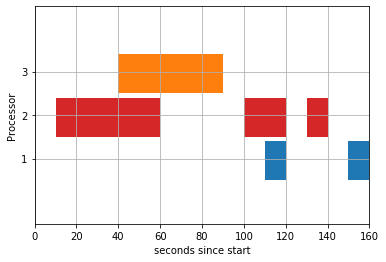

In [140]:

# Importing the matplotlb.pyplot 
import matplotlib.pyplot as plt 
  
# Declaring a figure "gnt" 
fig, gnt = plt.subplots() 
  
# Setting Y-axis limits 
gnt.set_ylim(0, 50) 
  
# Setting X-axis limits 
gnt.set_xlim(0, 160) 
  
# Setting labels for x-axis and y-axis 
gnt.set_xlabel('seconds since start') 
gnt.set_ylabel('Processor') 
  
# Setting ticks on y-axis 
gnt.set_yticks([15, 25, 35]) 
# Labelling tickes of y-axis 
gnt.set_yticklabels(['1', '2', '3']) 
  
# Setting graph attribute 
gnt.grid(True) 
  
# Declaring a bar in schedule 
 
gnt.broken_barh([(40, 50)], (30, 9), facecolors =('tab:orange')) 
  
# Declaring multiple bars in at same level and same width 
gnt.broken_barh([(110, 10), (150, 10)], (10, 9), 
                         facecolors ='tab:blue') 
  
gnt.broken_barh([(10, 50), (100, 20), (130, 10)], (20, 9), 
                                  facecolors =('tab:red')) 